# Data Exploration


The goal of this document is to articulate some important information regarding the source data of this analysis. Here, the data is explored, and key insights are drawn on the original dataset before data cleaning occurs.

In [8]:
import csv, os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [9]:
BASE_DIR = os.path.dirname(os.getcwd())

In [10]:
DATASET_PATH = os.path.join(BASE_DIR,"dataset","KT3")

files = os.listdir(DATASET_PATH)

files[0]

'u533092.csv'

In the dataset, each individual file represents an individual user on the platform. Each csv file follows the pattern "u{id}.csv", where "u" denotes that the files is of an individual user and the id is the account id of said user on the multi-platform AI tutoring service in Korea, Santa. Each csv file contains all of the interactions of each user and the platform. As different users spend different amounts of time on the platform, the csv files are of different lengths.

In [11]:
sample_files = random.sample(files,5)

for file in sample_files:
    csv_file_length = len(list(csv.reader(open(os.path.join(DATASET_PATH,file),"r"))))
    print(f"{file} has a length of {csv_file_length} lines")


u12378.csv has a length of 17631 lines
u526978.csv has a length of 7 lines
u625407.csv has a length of 19 lines
u4990.csv has a length of 2580 lines
u817630.csv has a length of 4 lines


From an initial exploration of the data, we see that most of the csv files seem to have only a few lines to them. This is a conjecture developed by rerunning the above cell block a few times, rarely getting any file that exceeds 200 lines. To further explore this mini-hypothesis, the length of the constituent files of the dataset is graphed below.

In [12]:
length = []
ids = []

for file in files:
    length.append(len(list(csv.reader(open(os.path.join(DATASET_PATH,file),"r")))))
    ids.append(file[:-4])

temp_df = pd.DataFrame({"file_id":ids,"file_size":length})
temp_df.head(5)

,file_id,file_size
0,u533092,44
1,u5901,426
2,u734989,16
3,u763609,110
4,u347548,32


(count    297915.000000
 mean        300.651424
 std        1428.706320
 min           3.000000
 25%          19.000000
 50%          28.000000
 75%          78.000000
 max      169818.000000
 Name: file_size, dtype: float64,
 <Axes: >)

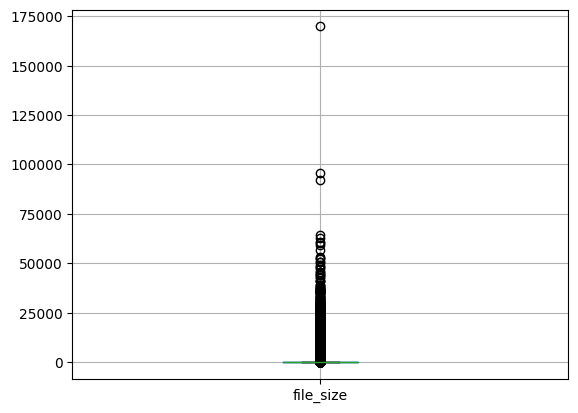

In [13]:
temp_df["file_size"].describe(), temp_df.boxplot()

In [14]:
upper_bound_outlier = (temp_df["file_size"].quantile(.75) - temp_df["file_size"].quantile(.25)) * 1.5 + temp_df["file_size"].quantile(.75)
upper_bound_outlier

np.float64(166.5)

In [15]:
outlier_files = len(temp_df[temp_df["file_size"] <= 166])
outlier_files

247124

As observed above, it seems that most of the records are consistenly 20 lines long, with any file over 166 lines long being considered a high outlier. This may indicate that the vast majority of users who use this platform use it only once or twice before never using it again. 

This could most likely be due to the free trial that the platform offers, indicating most users do not return after the free trial. This also explains the discrepancy between the reported userbase of the app and the number of csv files in the sample.

As for the structure of the data itself, the dataset stores the timestamps of when students start watching and end watching lectures, but do not actually store the actual length of the lecture. This may skew results if some students watch lectures that are generally longer than other lectures, potentially creating a rift between advanced and novice students. Therefore, this analysis will be using the proportion of video watched instead of minutes spent on lecture. Due to this, the data on the length of a lecture should be retrieved from a store of all available lecture videos.

In [16]:
LECTURE_DIR = os.path.join(BASE_DIR,"dataset","lectures.csv")
lecture_df = pd.read_csv(LECTURE_DIR)
lecture_df.head(5)

,lecture_id,part,tags,video_length,deployed_at
0,l520,5,142,-1,-1
1,l592,6,142,-1,-1
2,l1259,1,222,359000,1570424729123
3,l1260,1,220,487000,1570424738105
4,l1261,1,221,441000,1570424743162


One of the things immidiately evident is the pressence of "-1" denoting a missing value for video length and time of deployment, indicating that some videos may have never been released or were taken down.

In [17]:
lecture_df.isin([-1]).sum()

lecture_id        0
part            437
tags            437
video_length    480
deployed_at     453
dtype: int64

In [18]:
lecture_length = len(lecture_df)
lecture_length

1021

It seems that a lot of the lectures do not have video lengths. This may force a droppage of a large number of student data points if these lectures are taken by the students.

The following code attempts to check exactly how many of the data points of student data would have to be dropped if proceeding with lecture watch time as a proportion and not a quantitative variable.

In [19]:
lecture_df["data_available"] = lecture_df["video_length"] != -1
available_lecture_check = {row["lecture_id"]:row["data_available"] for _, row in lecture_df.iterrows()}

In [20]:
drop = []
for file_name in os.listdir(DATASET_PATH):
    with open(os.path.join(DATASET_PATH,file_name),"r") as file:
        reader = csv.reader(file)
        #to skip file header
        next(reader)

        for line in reader:
            if line[2] and line[2][0] == "l":
                if not available_lecture_check.get(line[2],0):
                    #add the user name to the drop list
                    drop.append(file_name[:-4])
                    break
                
drop = pd.DataFrame({"student_id":drop})
drop.head(5)

,student_id
0,u485334
1,u483745
2,u300603
3,u683931
4,u510893


In [21]:
len(drop)

16303

In [22]:
len(drop) / len(os.listdir(DATASET_PATH))

0.0547236627897219

Although almost half of the lecture videos are missing length data, only around 5% of the total student data points use some of these lectures. This does not seem horrible to drop. However, this 5% could primarily include older students, who may have watched certain lectures before they were taken down. To explore this, the line counts of the would be drops are compared with the overall line counts to determine if this hypothesis could hold true.

In [23]:
check = []
for _, row in temp_df.iterrows():
    if drop["student_id"].isin([row["file_id"]]).sum():
        check.append(row["file_size"])

check = pd.DataFrame({"data":check})
check["data"].describe(), temp_df["file_size"].describe()

(count     16303.000000
 mean       2412.318040
 std        4439.874048
 min           3.000000
 25%         326.000000
 50%        1017.000000
 75%        2652.000000
 max      169818.000000
 Name: data, dtype: float64,
 count    297915.000000
 mean        300.651424
 std        1428.706320
 min           3.000000
 25%          19.000000
 50%          28.000000
 75%          78.000000
 max      169818.000000
 Name: file_size, dtype: float64)

In [24]:
len(check["data"])

16303

From this analysis, it can be seen that the older users who have more time logged with the application would make up the majority of the dropped values. Because of this, this analysis will not be using proportions, and will accept the limitation of lecture length differences as opposed to newer and older user differences.

The responses and questions are stored in a similar manner. The main KT3 dataset only stores the user answer to the question, but not whether or not the answer was correct, or what the correct answer was. For this, we need to consult a seperate spreadsheet of all question ids and their corresponding correct answers. The same checks as before are made to ensure the quality of this data.

In [25]:
QUESTION_DIR = os.path.join(BASE_DIR,"dataset","questions.csv")
question_df = pd.read_csv(QUESTION_DIR)
question_df.head(5)

,question_id,bundle_id,explanation_id,correct_answer,part,tags,deployed_at
0,q1,b1,e1,b,1,1;2;179;181,1558093217098
1,q2,b2,e2,a,1,15;2;182,1558093219720
2,q3,b3,e3,b,1,14;2;179;183,1558093222784
3,q4,b4,e4,b,1,9;2;179;184,1558093225357
4,q5,b5,e5,c,1,8;2;179;181,1558093228439


In [26]:
question_df.isin([-1]).sum()

question_id          0
bundle_id            0
explanation_id       0
correct_answer       0
part                 0
tags                 0
deployed_at       2101
dtype: int64

As there do not seem to be any questions missing a "correct answer" column, there are no observations that need to be dropped.